In [ ]:
!pip install eofs
!pip install esem
!pip install utils
!pip install netCDF4
!pip install xarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eofs: filename=eofs-1.4.0-py3-none-any.whl size=1100355 sha256=fbbc566da4c82478c2de622c32411d7daca51ff9cc5f01012bdc690847983e3a
  Stored in directory: /root/.cache/pip/wheels/3d/69/36/c8bd247900ab5ade980a418ac2faed41e08f5006f7c369282f
Successfully built eofs
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.2 MB/s eta 0:00:00


In [ ]:
!pip install cartopy
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 59.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 6.1 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11102720 sha256=61d91fb9284d0032ed71af3dc9159f7e916099934cc0a09bf930e3b158c92131
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy
E: Unable to locate package python-cartopy
Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.5/275.5 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.tom

In [ ]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.linear_model import LinearRegression

from eofs.xarray import Eof

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
data_path = "/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/"

# path to save the netcdf file
path_output = data_path + 'outputs_ssp245_prediction_pattern2.nc'

# path to testing data (ssp245)
pathssp245_Y = 'outputs_ssp245.nc'
pathssp245_X = 'inputs_ssp245.nc'

In [ ]:
# Utilities for normalizing the emissions data
min_co2 = 0.
max_co2 = 2400
def normalize_co2(data):
    return data / max_co2

def un_normalize_co2(data):
    return data * max_co2

min_ch4 = 0.
max_ch4 = 0.6
def normalize_ch4(data):
    return data / max_ch4

def un_normalize_ch4(data):
    return data * max_ch4

data_path = "/content/gdrive/MyDrive/climate_emulator_duncan_parris/train_val1/"

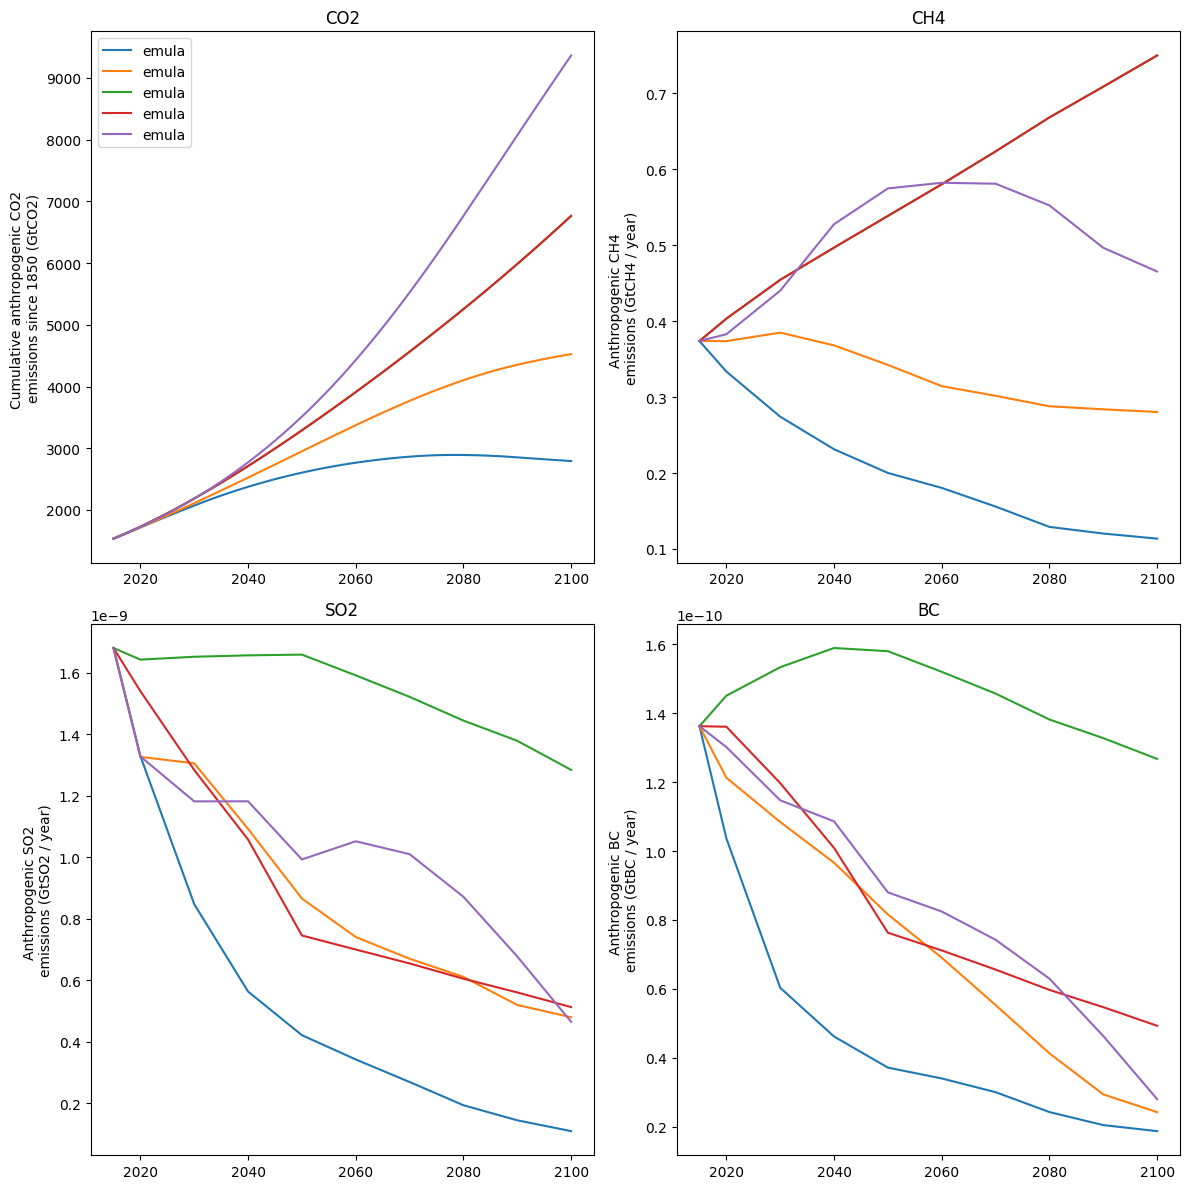

In [ ]:
from glob import glob

inputs = glob(data_path + "inputs_s*.nc")
SECONDS_IN_YEAR = 60*60*24*365 #s

fig, axes = plt.subplots(2, 2, figsize=(12,12))

for input in inputs:
    label=input.split('_')[1][:-3]
    X = xr.open_dataset(input)
    x = range(2015, 2101)

    weights = np.cos(np.deg2rad(X.latitude))

    axes[0, 0].plot(x, X['CO2'].data, label=label)
    axes[0, 0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
    axes[0, 1].plot(x, X['CH4'].data, label=label)
    axes[0, 1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
    # FIXME: Not sure where this factor of 1000 comes from...! Maybe the CEDS data is really g/m-2/s?
    axes[1, 0].plot(x, X['SO2'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*1e-9, label=label)
    axes[1, 0].set_ylabel("Anthropogenic SO2 \nemissions (GtSO2 / year)")
    axes[1, 1].plot(x, X['BC'].weighted(weights).sum(['latitude', 'longitude']).data*SECONDS_IN_YEAR*1e-9, label=label)
    axes[1, 1].set_ylabel("Anthropogenic BC \nemissions (GtBC / year)")

axes[0, 0].set_title('CO2')
axes[0, 1].set_title('CH4')
axes[1, 0].set_title('SO2')
axes[1, 1].set_title('BC')
axes[0, 0].legend()
plt.tight_layout()

In [ ]:
# Get one combined historical + ssp585 + ssp126 + ssp370 timeseries for now
X = xr.concat([xr.open_dataset(data_path + 'inputs_historical.nc'), xr.open_dataset(data_path + 'inputs_ssp585.nc'),xr.open_dataset(data_path+ 'inputs_ssp126.nc'),xr.open_dataset(data_path+ 'inputs_ssp370.nc')], dim='time').compute()

# Take the 2nd ensemble member for the historical (the first one has some missing DTR values for some reason...) and the 1st one for ssp585, ssp126, ssp370
Y = xr.concat([xr.open_dataset(data_path + 'outputs_historical.nc').sel(member=2), xr.open_dataset(data_path + 'outputs_ssp585.nc').sel(member=1),xr.open_dataset(data_path+ 'outputs_ssp126.nc').sel(member=1),xr.open_dataset(data_path+ 'outputs_ssp370.nc').sel(member=1)], dim='time').compute()

# Convert the precip values to mm/day
Y["pr"] *= 86400
Y["pr90"] *= 86400

X["time"]=np.arange(1,424)
Y["time"]=np.arange(1,424)

In [ ]:
weights = np.cos(np.deg2rad(Y.lat))
global_mean_temp = Y['tas'].weighted(weights).mean(['lat', 'lon']).to_pandas()

In [ ]:
def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data.mean()

In [ ]:
y_inp_tas=Y["tas"].stack(dim=["lat", "lon"])
y_inp_pr=Y["pr"].stack(dim=["lat", "lon"])
y_inp_pr90=Y["pr90"].stack(dim=["lat", "lon"])
y_inp_dtr=Y["diurnal_temperature_range"].stack(dim=["lat", "lon"])

In [ ]:
reg0 = LinearRegression(fit_intercept=False)
reg1 = LinearRegression(fit_intercept=False)
reg2 = LinearRegression(fit_intercept=False)
reg3 = LinearRegression(fit_intercept=False)

rf_tas = reg0.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_tas)
rf_pr = reg1.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_pr)
rf_pr90 = reg2.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_pr90)
rf_dtr = reg3.fit(global_mean_temp.to_numpy().reshape(-1, 1),y_inp_dtr)

In [ ]:
## Test on SSP245

test_Y = xr.open_dataset(data_path + pathssp245_Y).compute()
test_X = xr.open_dataset(data_path + pathssp245_X).compute()

tas_truth = test_Y["tas"].mean('member')
pr_truth = test_Y["pr"].mean('member') * 86400
pr90_truth = test_Y["pr90"].mean('member') * 86400
dtr_truth = test_Y["diurnal_temperature_range"].mean('member')

# Smooth out the internal variability otherwise it's cheating
test_inputs = test_Y['tas'].mean('member').weighted(weights).mean(['lat', 'lon']).to_pandas().rolling(10, min_periods=1).mean()
test_inputs

time
2015    0.724876
2016    0.749755
2017    0.763944
2018    0.799215
2019    0.836912
          ...   
2096    2.092425
2097    2.090614
2098    2.106942
2099    2.114485
2100    2.111920
Length: 86, dtype: float64

In [ ]:
m_out_t = rf_tas.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_p = rf_pr.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_p90 = rf_pr90.predict(test_inputs.to_numpy()[:, np.newaxis])
m_out_d = rf_dtr.predict(test_inputs.to_numpy()[:, np.newaxis])

m_out_tas = m_out_t.reshape(86, 96, 144)
m_out_pr = m_out_p.reshape(86, 96, 144)
m_out_pr90 = m_out_p90.reshape(86, 96, 144)
m_out_dtr = m_out_d.reshape(86, 96, 144)

In [ ]:
xr_output=xr.Dataset(coords={'time': test_X.time.values, 'lat': test_X.latitude.values, 'lon': test_X.longitude.values})
xr_output["tas"]=(['time', 'lat', 'lon'],  m_out_tas)
xr_output["diurnal_temperature_range"]=(['time', 'lat', 'lon'],  m_out_dtr)
xr_output["pr"]=(['time', 'lat', 'lon'],  m_out_pr)
xr_output["pr90"]=(['time', 'lat', 'lon'],  m_out_pr90)

#save output to netcdf
xr_output.to_netcdf(path_output,'w')

In [23]:
dtr_truth

<xarray.DataArray 'diurnal_temperature_range' (time: 86, lat: 96, lon: 144)>
array([[[ 9.79756489e-02,  9.79758129e-02,  9.80059281e-02, ...,
          9.80025902e-02,  9.80037823e-02,  9.79924202e-02],
        [ 6.16879463e-02,  6.43920898e-02,  7.08022118e-02, ...,
          5.69362640e-02,  5.81933670e-02,  5.34936599e-02],
        [ 1.12694101e-02,  1.94269810e-02,  2.63059139e-02, ...,
         -3.24455909e-02, -2.16657314e-02, -4.97746468e-03],
        ...,
        [-2.12274477e-01, -2.09817246e-01, -2.05649212e-01, ...,
         -2.25654528e-01, -2.22638056e-01, -2.15302542e-01],
        [-1.55575350e-01, -1.55482605e-01, -1.52526066e-01, ...,
         -1.48481533e-01, -1.46849081e-01, -1.50227308e-01],
        [-1.32002041e-01, -1.28492042e-01, -1.23165287e-01, ...,
         -1.32138327e-01, -1.32087469e-01, -1.32040262e-01]],

       [[ 1.97382774e-02,  1.97656956e-02,  1.97492447e-02, ...,
          1.97685566e-02,  1.97720528e-02,  1.97533760e-02],
        [ 3.66131472e-03,  8.23410321e-03,  1.20267076e-02, ...,
          2.07575154e-03,  2.70620990e-03,  3.77527880e-03],
        [ 5.05638123e-03,  5.11733675e-03,  1.69951115e-02, ...,
          3.46899033e-03,  1.26727426e-03, -5.89052856e-04],
...
         -8.72241557e-01, -8.78030360e-01, -8.73824418e-01],
        [-7.46892452e-01, -7.42045879e-01, -7.37796068e-01, ...,
         -7.40901232e-01, -7.39286125e-01, -7.41427183e-01],
        [-6.33853436e-01, -6.28105342e-01, -6.20950460e-01, ...,
         -6.32082105e-01, -6.32551730e-01, -6.33134425e-01]],

       [[-1.13232531e-01, -1.13329567e-01, -1.13356113e-01, ...,
         -1.13256775e-01, -1.13246761e-01, -1.13253832e-01],
        [-4.78704758e-02, -4.02298756e-02, -4.20846157e-02, ...,
         -5.98537140e-02, -5.39700985e-02, -5.21594696e-02],
        [-6.07728958e-02, -3.68359089e-02, -1.58375110e-02, ...,
         -9.82303619e-02, -9.11461487e-02, -8.18969384e-02],
        ...,
        [-5.64880848e-01, -5.61615646e-01, -5.62965214e-01, ...,
         -5.48306763e-01, -5.57397664e-01, -5.60488999e-01],
        [-4.71895367e-01, -4.77507681e-01, -4.86558348e-01, ...,
         -4.52404112e-01, -4.54440027e-01, -4.63181347e-01],
        [-4.34390068e-01, -4.30184215e-01, -4.24739361e-01, ...,
         -4.33257341e-01, -4.33557749e-01, -4.33942705e-01]]],
      dtype=float32)
Coordinates:
  * lat       (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time      (time) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100
    quantile  float64 0.9

In [ ]:
print(f"RMSE: {get_rmse(tas_truth[65:], m_out_tas[65:])}")
print(f"RMSE: {get_rmse(tas_truth[35:], m_out_tas[35:])}")
print("\n")

print(f"RMSE: {get_rmse(dtr_truth[65:], m_out_dtr[65:])}")
print(f"RMSE: {get_rmse(dtr_truth[35:], m_out_dtr[35:])}")
print("\n")

print(f"RMSE: {get_rmse(pr_truth[65:], m_out_pr[65:])}")
print(f"RMSE: {get_rmse(pr_truth[35:], m_out_pr[35:])}")
print("\n")

print(f"RMSE: {get_rmse(pr90_truth[65:], m_out_pr90[65:])}")
print(f"RMSE: {get_rmse(pr90_truth[35:], m_out_pr90[35:])}")

RMSE: 0.36672564854262624
RMSE: 0.3645433605213308


RMSE: 0.15430761396148504
RMSE: 0.15026689691168435


RMSE: 0.5628629212069906
RMSE: 0.5274828101441922


RMSE: 1.6134816436686719
RMSE: 1.532151236811704


In [ ]:
m_out_tas[65:].shape


(21, 96, 144)

[Text(0.5, 1.0, 'Difference')]

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


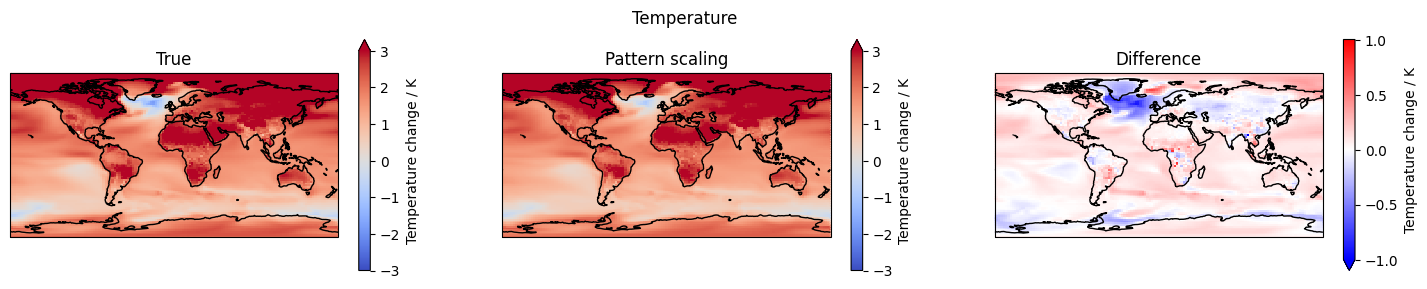

In [ ]:
# plotting predictions
# divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
# diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)
import cartopy.crs as ccrs

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
tas_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmax=3,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
xr_output["tas"].sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmax=3,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = tas_truth - xr_output["tas"]
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", vmax=1,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

[Text(0.5, 1.0, 'Difference')]

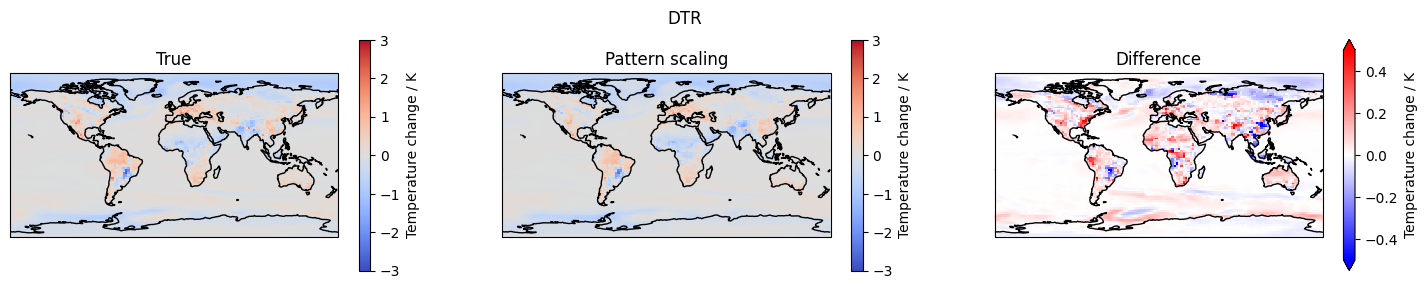

In [ ]:
# plotting predictions
# divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
# diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)
import cartopy.crs as ccrs

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('DTR')

# Test
plt.subplot(131, projection=proj)
dtr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmax=3,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
xr_output["diurnal_temperature_range"].sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmax=3,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = dtr_truth - xr_output["diurnal_temperature_range"]
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", vmax=0.5,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

[Text(0.5, 1.0, 'Difference')]

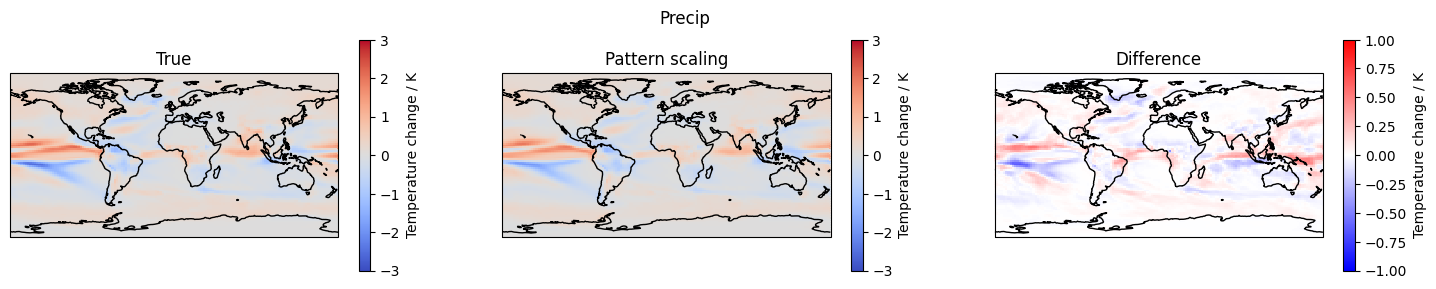

In [ ]:
# plotting predictions
# divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
# diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)
import cartopy.crs as ccrs

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Precip')

# Test
plt.subplot(131, projection=proj)
pr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmax=3,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
xr_output["pr"].sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmax=3,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = pr_truth - xr_output["pr"]
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", vmax=1,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

[Text(0.5, 1.0, 'Difference')]

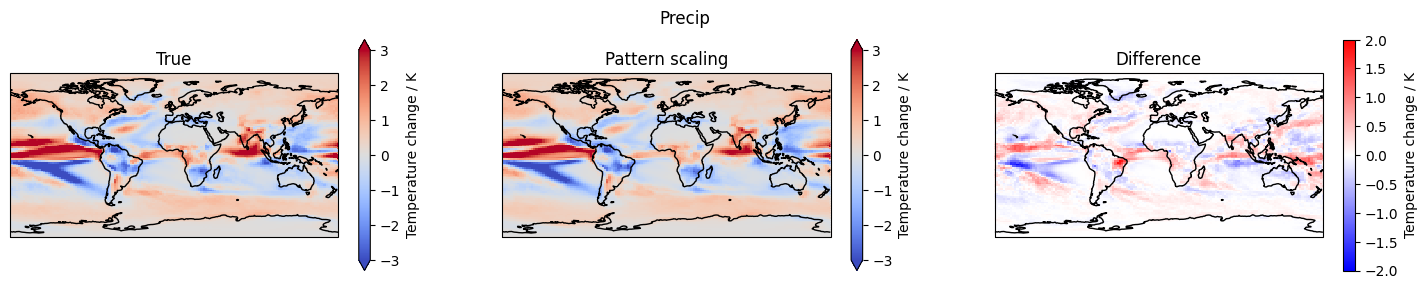

In [ ]:
# plotting predictions
# divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
# diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)
import cartopy.crs as ccrs

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Precip')

# Test
plt.subplot(131, projection=proj)
pr90_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmax=3,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
xr_output["pr90"].sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmax=3,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Pattern scaling')

# Difference
difference = pr90_truth - xr_output["pr90"]
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", vmax=2,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')